# If it doesn’t spread - it’s dead!


# Authors
- Silva Bashllari, S123456    
- Alejandro Mesa Gómez, S306638    

# Data and dependencies

In [1]:
%%bash

if [ ! -d 'data/' ]; then
    mkdir data
fi

if [ ! -f 'data/development.csv'  ] && [ ! -f 'data/evaluation.csv'  ]; then
    # This are the original given files, but stored in a git repository to allow download automation
    wget -nv https://raw.githubusercontent.com/cosmolejo/dataRepo/master/summer_project_dataset/development.csv
    wget -nv https://raw.githubusercontent.com/cosmolejo/dataRepo/master/summer_project_dataset/evaluation.csv
    mv -t data/ evaluation.csv development.csv
fi

pip -q install -r requirements.txt --user

# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.svm import SVR
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import sweetviz as sv
import seaborn as sns

import skorch
from skorch import NeuralNetRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
pd.options.display.max_columns = 200

In [3]:
df_all = pd.read_csv('data/development.csv')

# EDA

In [4]:
df_all.head()

,id,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel,weekday
0,0,http://mashable.com/2014/09/08/safest-cabbies-...,121.0,12.0,1015.0,0.422018,1.0,0.545031,10.0,6.0,33.0,1.0,4.656158,4.0,-1.0,263.0,110.500000,6500.0,843300.0,398350.000000,1809.075,3483.806797,2729.047648,1100.0,22100.0,6475.0,0.331582,0.050050,0.050035,0.050000,0.518333,0.471175,0.159889,0.041379,0.008867,0.823529,0.176471,0.333534,0.100000,0.8,-0.160714,-0.50,-0.071429,0.0,0.00,0.5,0.00,2900,bus,tuesday
1,1,http://mashable.com/2013/07/25/3d-printed-rifle/,532.0,9.0,503.0,0.569697,1.0,0.737542,9.0,0.0,NaN,1.0,4.576541,10.0,4.0,3200.0,524.750000,0.0,843300.0,117960.000000,0.000,4228.114286,2387.526307,0.0,0.0,0.0,0.020007,0.020008,0.325602,0.020004,0.614379,0.477791,0.123520,0.033797,0.019881,0.629630,0.370370,0.419786,0.136364,1.0,-0.157500,-0.25,-0.100000,0.0,0.00,0.5,0.00,1300,tech,thursday
2,2,http://mashable.com/2013/10/30/digital-dinosau...,435.0,9.0,232.0,0.646018,1.0,0.748428,12.0,3.0,4.0,1.0,4.935345,6.0,4.0,939.0,198.666667,970.0,843300.0,573878.333333,954.500,6192.239067,4385.022237,1400.0,58800.0,30100.0,0.033334,0.033697,0.033333,0.866302,0.033333,0.522234,-0.163235,0.017241,0.043103,0.285714,0.714286,0.468750,0.375000,0.5,-0.427500,-1.00,-0.187500,0.0,0.00,0.5,0.00,17700,lifestyle,wednesday
3,3,http://mashable.com/2014/08/27/homer-simpson-i...,134.0,12.0,171.0,0.722892,1.0,0.867925,9.0,5.0,0.0,NaN,4.970760,6.0,-1.0,2100.0,444.166667,5600.0,843300.0,311033.333333,2076.520,4529.427500,3269.856640,974.0,5600.0,2574.8,0.700107,0.033335,0.033334,0.199402,0.033822,0.405128,-0.006410,0.011696,0.029240,0.285714,0.714286,0.500000,0.500000,0.5,-0.216667,-0.25,-0.166667,0.4,-0.25,0.1,0.25,1500,bus,wednesday
4,4,http://mashable.com/2013/01/10/creepy-robotic-...,728.0,11.0,286.0,0.652632,1.0,0.800000,5.0,2.0,NaN,0.0,5.006993,NaN,217.0,552.0,356.200000,0.0,28000.0,6830.125000,0.000,2240.536313,976.913444,822.0,822.0,822.0,0.214708,0.025062,0.025016,0.025187,0.710028,0.418036,0.060089,0.034965,0.024476,0.588235,0.411765,0.303429,0.100000,0.6,-0.251786,-0.50,-0.100000,0.2,-0.10,0.3,0.10,1400,tech,thursday


In [5]:
# all the articles seem to be from "mashable.com" thus the prediction of the number of shares is not generalizable for other sites.
print(df_all.loc[10001:10501, 'url'])

10001    http://mashable.com/2013/04/30/worlds-first-we...
10002     http://mashable.com/2013/09/09/icahn-dell-fight/
10003    http://mashable.com/2013/03/12/the-bachelor-so...
10004    http://mashable.com/2013/06/05/ticket-to-ride-...
10005    http://mashable.com/2014/07/15/fords-alan-mula...
                               ...                        
10497    http://mashable.com/2014/01/31/twitter-ibm-pat...
10498    http://mashable.com/2014/05/27/toshiba-cheap-w...
10499    http://mashable.com/2014/08/19/mara-wilson-rob...
10500       http://mashable.com/2013/11/14/snapchat-worth/
10501    http://mashable.com/2013/01/14/lance-armstrong...
Name: url, Length: 501, dtype: object


In [6]:
num = len(list(filter(lambda x: 'http://mashable.com/' in x,df_all.url)))
"All articles from mashable" if num == df_all.shape[0] else f"There're {df_all.shape[0]- num} articles from other sources"

'All articles from mashable'

In [7]:
df_all.describe()

,id,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,31715.00000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,25340.000000,25384.000000,31715.000000,25397.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000
mean,15857.00000,354.058206,10.390730,544.048179,0.530754,0.970140,0.672973,10.865143,3.274381,4.533899,1.259100,4.547096,7.220538,26.094624,1146.761240,310.665636,13537.952956,752156.547375,259272.219208,1115.519577,5645.840622,3131.505048,4026.917646,10300.539485,6436.010296,0.184310,0.142384,0.216083,0.223065,0.234158,0.443213,0.119204,0.039594,0.016627,0.681880,0.288134,0.353661,0.095466,0.756271,-0.259198,-0.521164,-0.107397,0.281647,0.069909,0.341805,0.155974,3407.068863
std,9155.47623,214.314223,2.115643,467.730448,0.137106,0.170203,0.154128,11.295386,3.822364,8.355645,4.176884,0.845050,1.904411,69.607933,3949.597979,621.518386,57773.417428,214790.290225,135230.002910,1136.724206,6173.405093,1329.314912,19928.490868,40806.007028,24493.111862,0.262799,0.221233,0.282044,0.294870,0.289054,0.116933,0.097157,0.017430,0.010892,0.190380,0.156324,0.104526,0.071362,0.247798,0.127508,0.290352,0.094932,0.323834,0.265514,0.188980,0.225957,11899.460219
min,0.00000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018183,0.018182,0.018182,0.018182,0.018182,0.000000,-0.393750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,4.000000
25%,7928.50000,163.000000,9.000000,246.000000,0.471276,1.000000,0.626028,4.000000,1.000000,1.000000,0.000000,4.477934,6.000000,-1.000000,445.000000,141.732143,0.000000,843300.000000,172748.571428,0.000000,3557.341810,2377.668653,642.000000,1100.000000,980.000000,0.025058,0.025014,0.028571,0.026685,0.028574,0.395910,0.057436,0.028374,0.009611,0.600000,0.185185,0.306108,0.050000,0.600000,-0.328333,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,15857.00000,338.000000,10.000000,409.000000,0.539568,1.000000,0.690909,7.000000,3.000000,1.000000,0.000000,4.664251,7.000000,-1.000000,659.000000,235.857143,1400.000000,843300.000000,244550.000000,1020.750000,4346.305556,2867.653996,1200.000000,2800.000000,2200.000000,0.033387,0.033346,0.040004,0.040001,0.040986,0.453431,0.118908,0.038961,0.015332,0.710526,0.280000,0.358929,0.100000,0.800000,-0.252976,-0.500000,-0.100000,0.144444,0.000000,0.500000,0.000000,1400.000000
75%,23785.50000,542.000000,12.000000,713.000000,0.608523,1.000000,0.754644,14.000000,4.000000,4.000000,1.000000,4.853503,9.000000,4.000000,1000.000000,357.112500,7800.000000,843300.000000,331200.000000,2056.403080,6016.750000,3595.493907,2600.000000,7900.000000,5166.666667,0

In [8]:
X = df_all.copy()
X = X.drop(['url'], axis = 1)

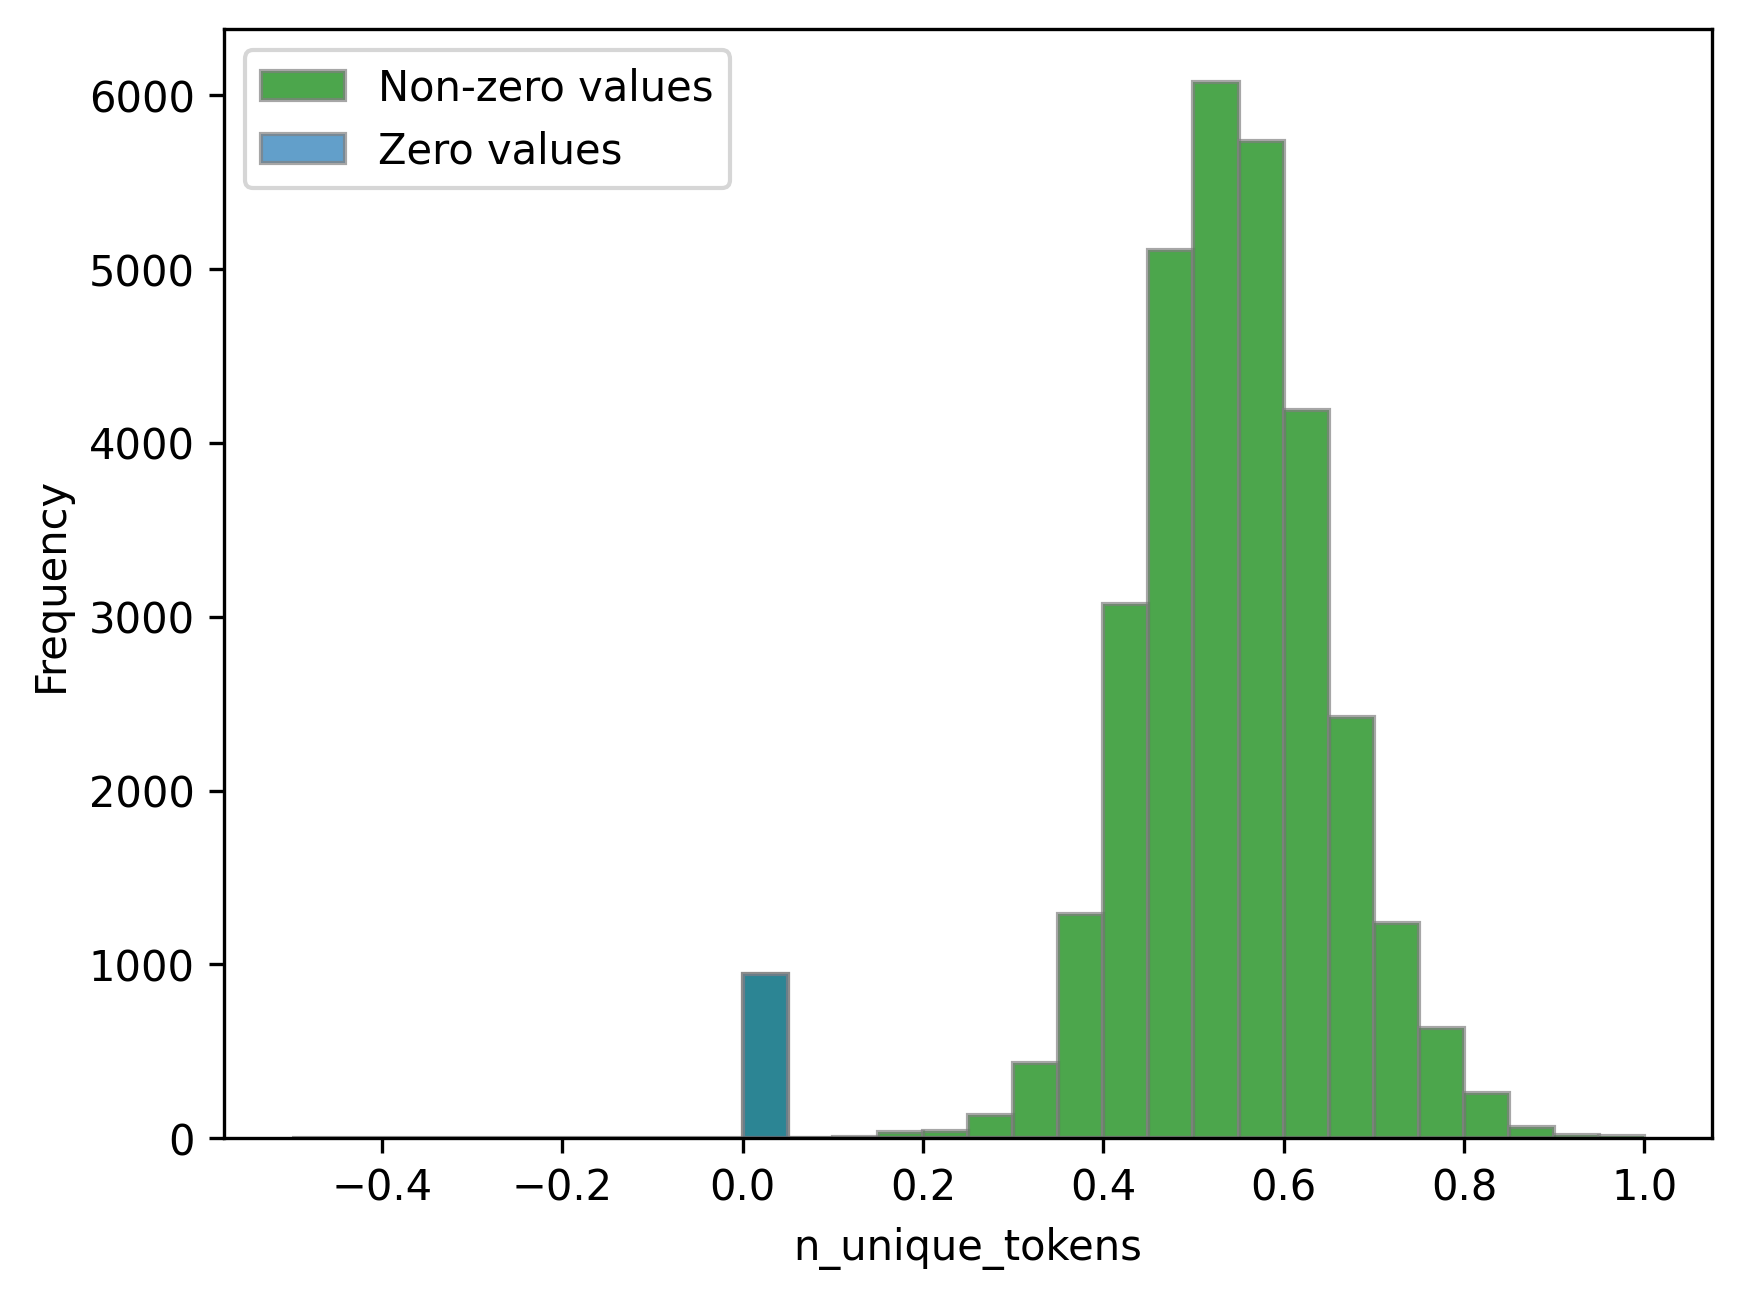

In [9]:
n_unique_tokens_data = X['n_unique_tokens']

# Plotting distribution of n_unique_tokens
plt.figure(dpi=300)
plt.hist(n_unique_tokens_data, bins=20, edgecolor='gray', color='green', alpha=0.7)
plt.hist(n_unique_tokens_data[n_unique_tokens_data == 0], bins=20, edgecolor='gray', alpha=0.7)
plt.xlabel('n_unique_tokens')
plt.ylabel('Frequency')
plt.legend(['Non-zero values', 'Zero values'])
# Save the image
plt.savefig('outliers.png')
plt.show()


In [10]:
df_pruned = df_all.copy()
df_pruned = df_pruned[(df_pruned['n_tokens_content'] != 0) | (df_pruned['n_unique_tokens'] != 0)]
X_prunned = X.copy()
X_prunned = X_prunned[(X_prunned['n_tokens_content'] != 0) | (X_prunned['n_unique_tokens'] != 0)]
y = X_prunned['shares']  # Target variable
X_prunned = X_prunned.drop('shares', axis=1)  # Features
for col in X_prunned.columns:
    X_prunned[col] = X_prunned[col].fillna(0)
categorical_columns = ['data_channel', 'weekday']
# Separate numerical columns
numerical_columns = [col for col in X_prunned.columns if col not in categorical_columns]

# Apply Min-Max scaling to numerical columns
scaler = MinMaxScaler()
X_scaled = X_prunned.copy()
X_scaled[numerical_columns] = scaler.fit_transform(X_scaled[numerical_columns])

X2 = pd.concat([X_scaled,pd.get_dummies(X_scaled['weekday'] ,prefix = 'weekday' )], axis=1)
X2 = X2.drop(['weekday'], axis=1)
X2 = pd.concat([X2,pd.get_dummies(X2['data_channel'] ,prefix = 'd_channel' )], axis=1)
X2 = X2.drop(['data_channel'], axis = 1)
X2 = X2.drop(['id'], axis = 1)

In [11]:
#EDA using Autoviz
#doesn't work with pandas 2.0 
#but the output is provided anyway

# sweet_report = sv.analyze(df_all) 


#Saving results to HTML file
# sweet_report.show_html('sweet_report.html')

Press the following button to open the sweetviz EDA

<a href="sweet_report.html" target="popup" onclick="window.open('sweet_report.html','popup','width=w,height=h'); return false;" >
    <button type="button">
        Open SweetViz Report
    </button>
</a>



In [12]:
for col in df_all.columns:
  condition = df_all[col].isnull().values.sum()
  if condition > 0:
    print(f'{col} -> {condition}/{df_all.shape[0]} NAN')

num_imgs -> 6375/31715 NAN
num_videos -> 6331/31715 NAN
num_keywords -> 6318/31715 NAN


## tokens filtering


In [13]:
df_url_n_tokens_content_n_unique_tokens   = df_all.loc[:,['url','n_tokens_content','n_unique_tokens']]
df_url_n_tokens_content_n_unique_tokens = df_url_n_tokens_content_n_unique_tokens[
    (df_url_n_tokens_content_n_unique_tokens['n_tokens_content'] != 0) | (df_url_n_tokens_content_n_unique_tokens['n_unique_tokens'] != 0)]

df_url_n_tokens_content_n_unique_tokens.head()

,url,n_tokens_content,n_unique_tokens
0,http://mashable.com/2014/09/08/safest-cabbies-...,1015.0,0.422018
1,http://mashable.com/2013/07/25/3d-printed-rifle/,503.0,0.569697
2,http://mashable.com/2013/10/30/digital-dinosau...,232.0,0.646018
3,http://mashable.com/2014/08/27/homer-simpson-i...,171.0,0.722892
4,http://mashable.com/2013/01/10/creepy-robotic-...,286.0,0.652632


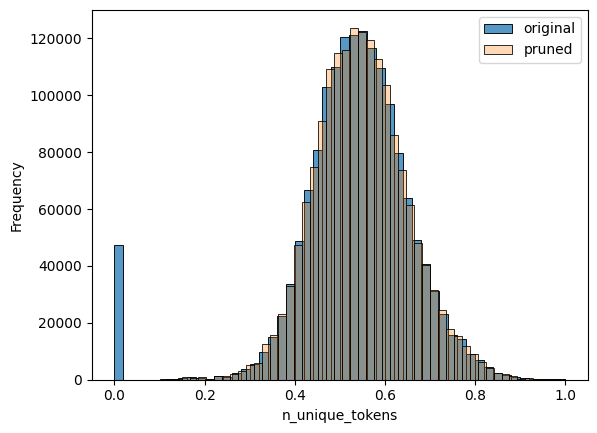

In [14]:
#df_url_n_tokens_content_n_unique_tokens.n_tokens_content.plot(kind='hist')
sns.histplot(df_all.n_unique_tokens,             
             bins=50, label='original', stat='frequency');
sns.histplot(df_url_n_tokens_content_n_unique_tokens.n_unique_tokens,             
             bins=50, label='pruned', alpha=0.3 , stat='frequency');
plt.legend()


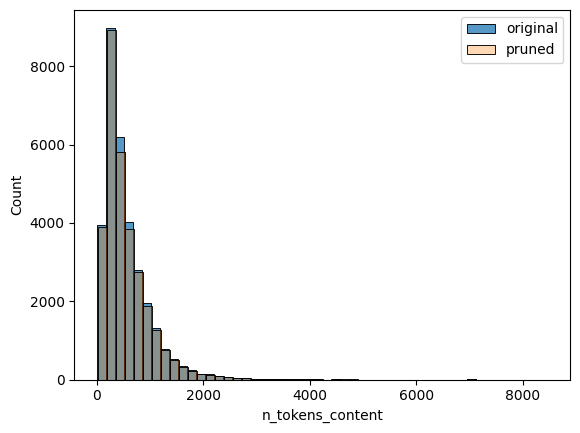

In [15]:
#df_url_n_tokens_content_n_unique_tokens.n_tokens_content.plot(kind='hist')
sns.histplot(df_all.n_tokens_content,             
             bins=50, label='original');
sns.histplot(df_url_n_tokens_content_n_unique_tokens.n_tokens_content,             
             bins=50, label='pruned', alpha=0.3);
plt.legend()

In [16]:
df_all[(df_all['n_tokens_content']>100) & (df_all['n_tokens_content']<200)].id.count()

3963

In [17]:
df_url_n_tokens_content_n_unique_tokens[
    (df_url_n_tokens_content_n_unique_tokens['n_tokens_content']>100) & (df_url_n_tokens_content_n_unique_tokens['n_tokens_content']<200)
    ].url.count()

3963

In [18]:
df_all.n_unique_tokens.describe()

count    31715.000000
mean         0.530754
std          0.137106
min          0.000000
25%          0.471276
50%          0.539568
75%          0.608523
max          1.000000
Name: n_unique_tokens, dtype: float64

In [19]:
df_url_n_tokens_content_n_unique_tokens[
    (df_url_n_tokens_content_n_unique_tokens['n_unique_tokens']>0.3) & (df_url_n_tokens_content_n_unique_tokens['n_unique_tokens']<0.5)
    ].url.count()

10001

In [20]:
df_all[(df_all['n_unique_tokens']>0.3) & (df_all['n_unique_tokens']<0.5)].id.count()

10001

(0.0, 40000.0)

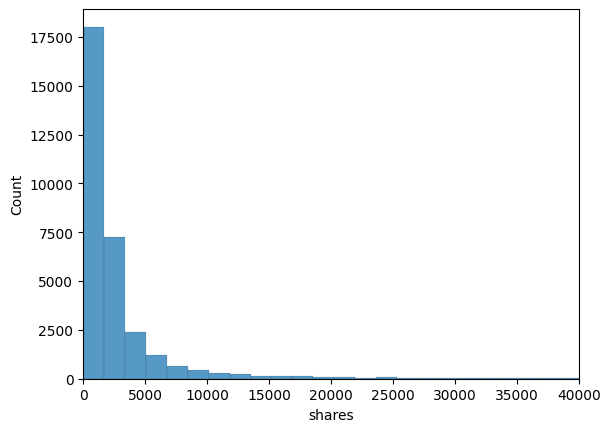

In [21]:
#df_url_n_tokens_content_n_unique_tokens.n_tokens_content.plot(kind='hist')
sns.histplot(df_all.shares,             
             bins=500, label='original');
plt.xlim(0,40000)

<Axes: xlabel='rate_positive_words', ylabel='shares'>

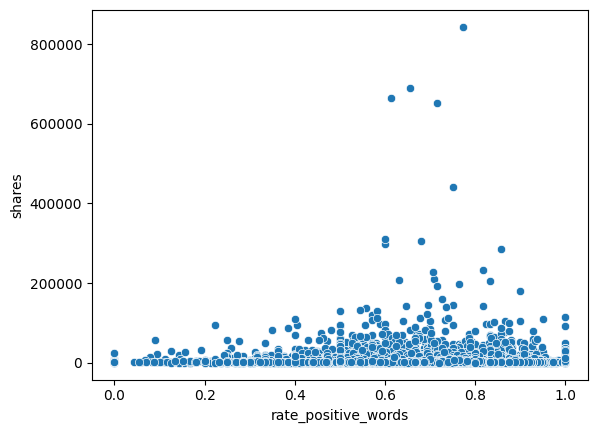

In [22]:
sns.scatterplot(df_pruned, x='rate_positive_words', y= 'shares')

<Axes: xlabel='global_rate_negative_words', ylabel='shares'>

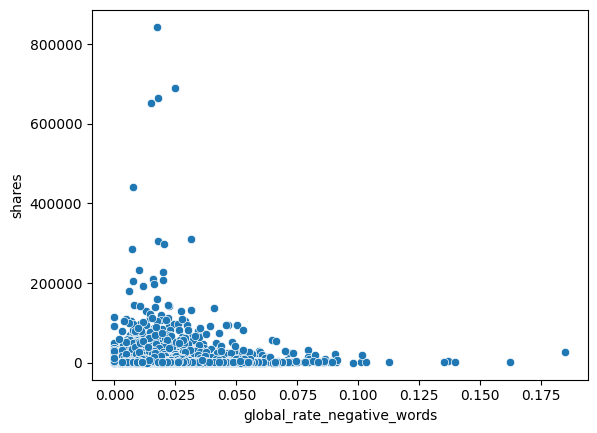

In [23]:
sns.scatterplot(df_pruned, x='global_rate_negative_words', y= 'shares')

<Axes: xlabel='rate_negative_words', ylabel='shares'>

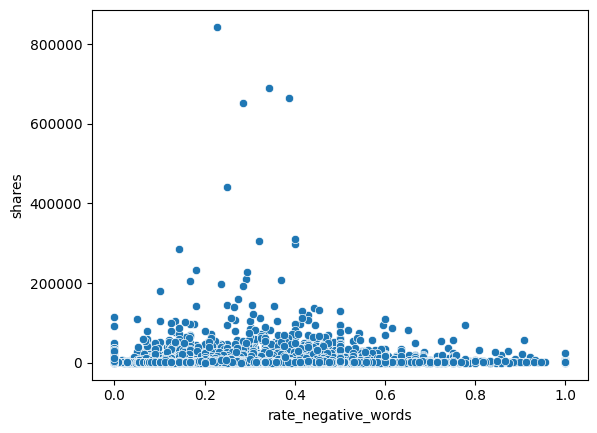

In [24]:
sns.scatterplot(df_pruned, x='rate_negative_words', y= 'shares')

# Visualization

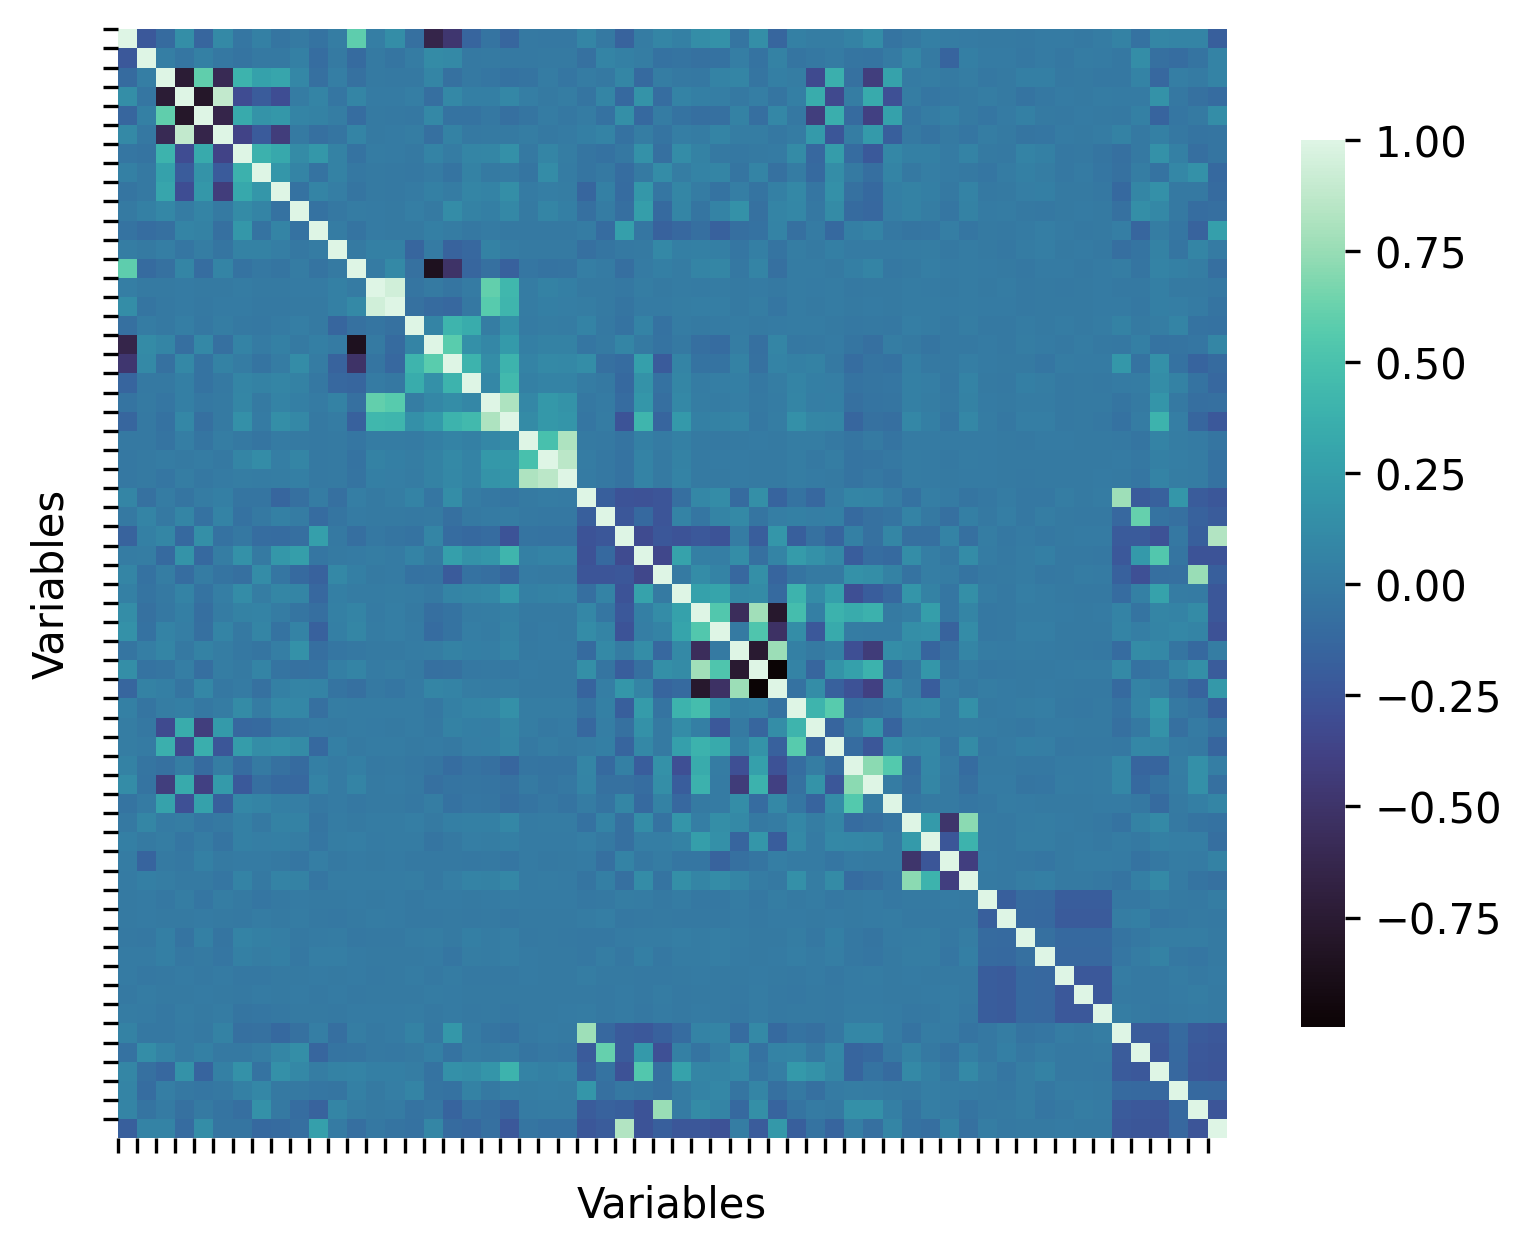

In [26]:
# Extract the subset of the dataframe with the top 20 variables

# Calculate the correlation matrix
corr_matrix = X2.corr()

# Create a figure and axes for the heatmap
fig, ax = plt.subplots( dpi=300)
#figsize=(20, 20)
# Create the heatmap using matshow
# heatmap = ax.matshow(corr_matrix, cmap='mako')

# Create colorbar
# cbar = plt.colorbar(heatmap)
heatmap=sns.heatmap(corr_matrix,cmap='mako',annot=False,square=True,ax=ax,
                    cbar_kws={"shrink": 0.8})

# Set tick labels and positions
ax.set_xticks(range(len(X2.columns)))
ax.set_yticks(range(len(X2.columns)))
ax.set_xticklabels([])
ax.set_yticklabels([])

# Add title and axis labels
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.savefig('heatmap.png')
# Show the heatmap
plt.show()


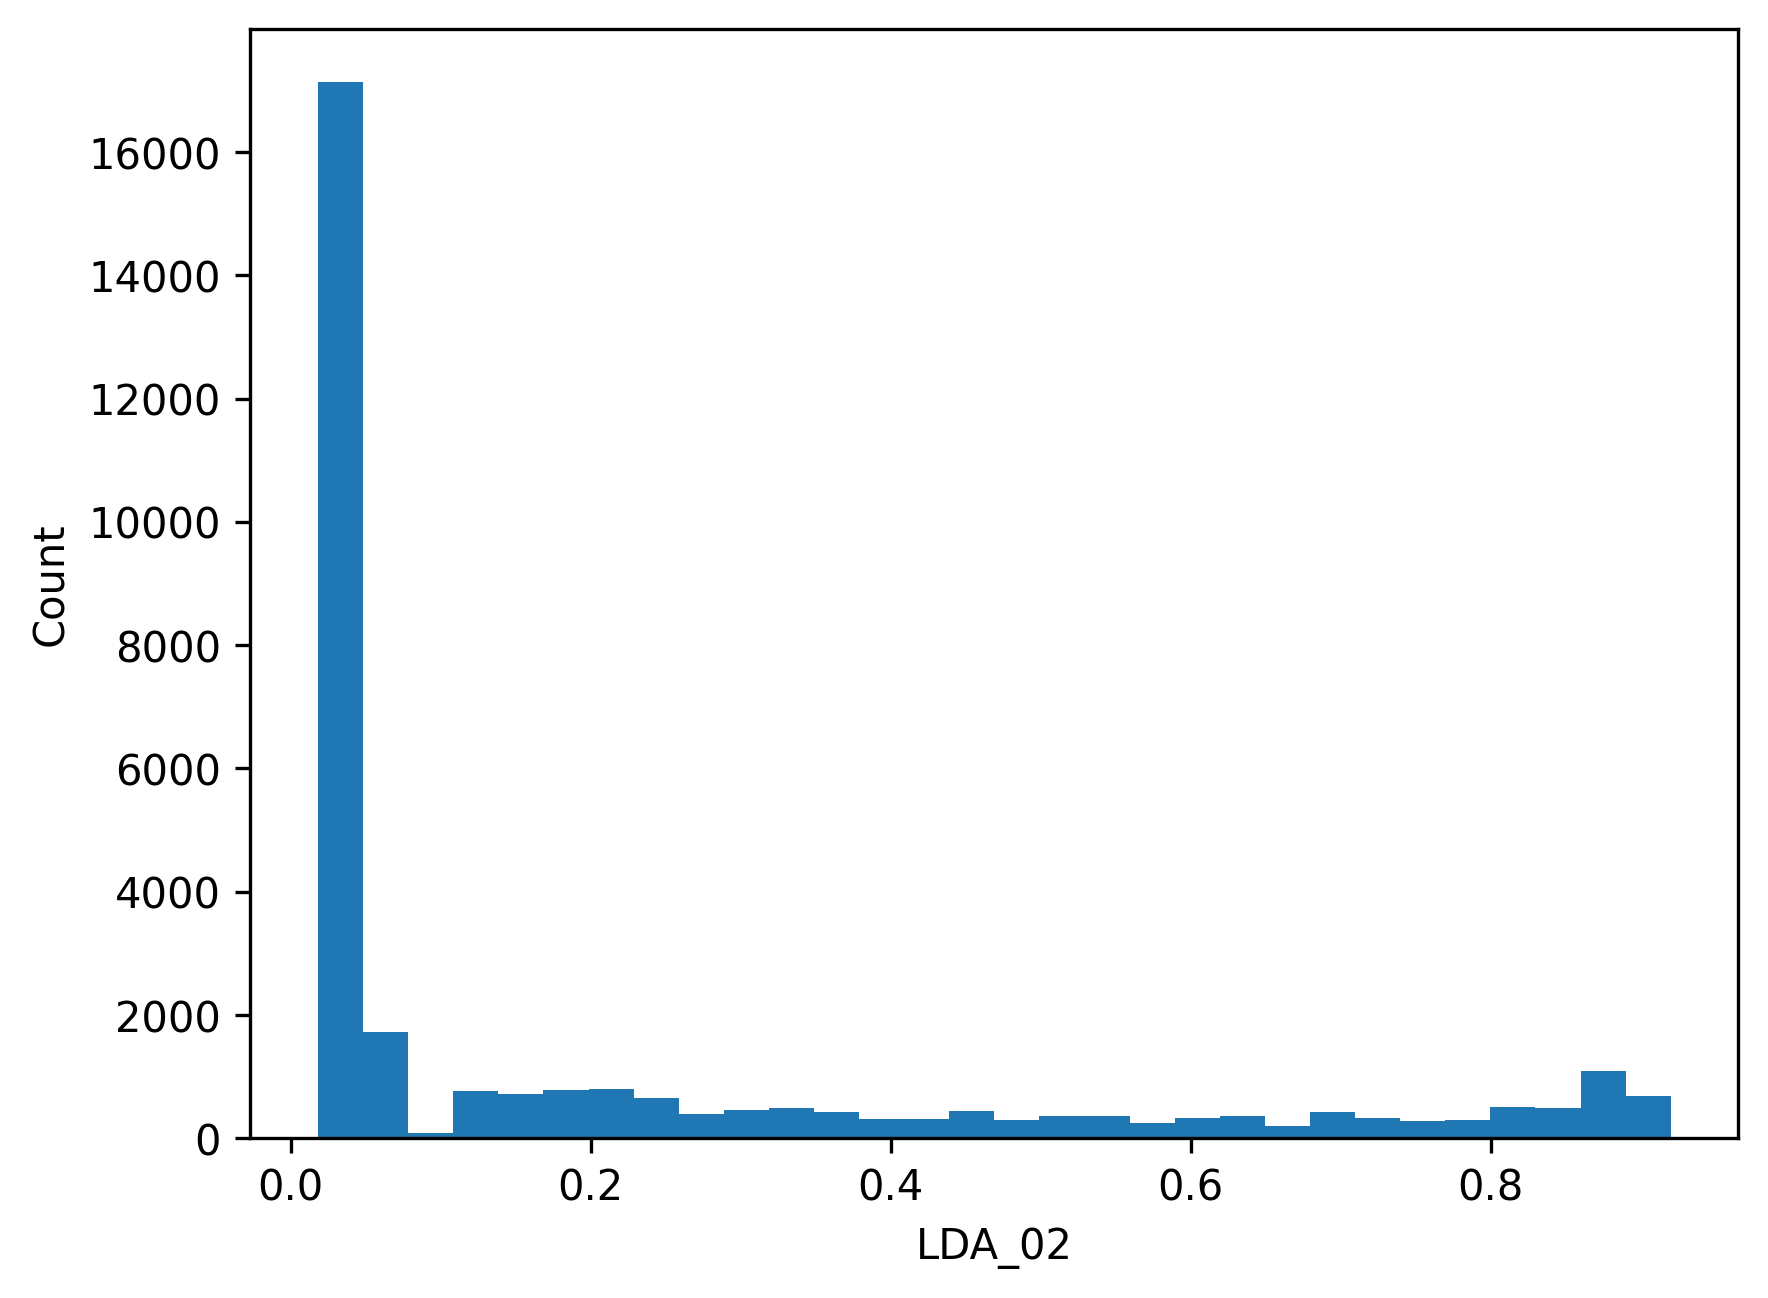

In [27]:
plt.figure(dpi=300)
plt.hist(X.loc[:,'LDA_02'],bins=30)
# plt.xlim(0,15000)
plt.xlabel("LDA_02")
plt.ylabel("Count")
plt.savefig('LDA_02.png')
plt.show()

# Vanilla regressions

In [10]:
X2 = pd.concat([X_prunned,pd.get_dummies(X_prunned['weekday'] ,prefix = 'weekday' )], axis=1)
X2 = X2.drop(['weekday'], axis=1)
X2 = pd.concat([X2,pd.get_dummies(X2['data_channel'] ,prefix = 'd_channel' )], axis=1)
X2 = X2.drop(['data_channel'], axis = 1)

In [11]:
fisher_scores, _ = f_classif(X2, y)
# Create a new dataframe or series to store the feature names and their corresponding Fisher scores
feature_scores = pd.DataFrame({'Feature': X2.columns, 'Fisher Score': fisher_scores})

# Sort the feature scores in descending order
feature_scores.sort_values(by='Fisher Score', ascending=False, inplace=True)
feature_scores.reset_index(drop=True, inplace=True)


In [12]:
top_20_features = feature_scores.loc[:20, 'Feature']
top_15_features = feature_scores.loc[:15, 'Feature']
top_10_features = feature_scores.loc[:10, 'Feature']
top_20_features

0                    kw_avg_avg
1               d_channel_world
2                        LDA_02
3                    kw_max_min
4                    kw_max_avg
5           d_channel_lifestyle
6                    kw_avg_min
7                        LDA_03
8       d_channel_entertainment
9           global_subjectivity
10                   kw_min_max
11                    num_hrefs
12                       LDA_01
13    global_sentiment_polarity
14                   kw_min_avg
15          rate_negative_words
16          rate_positive_words
17                       LDA_04
18    self_reference_max_shares
19        max_negative_polarity
20                   num_videos
Name: Feature, dtype: object

In [13]:
# X3 = X2.loc[:,top_20_features ]
X4 = X2.loc[:,top_10_features ]
X5 = X2.loc[:,top_15_features ]

## Test Dataset

In [14]:
# Separate numerical columns
XT_scaled = df_test.copy().drop(['url','id',],axis=1)
numerical_columns = [col for col in XT_scaled.columns if col not in categorical_columns]

# Apply Min-Max scaling to numerical columns


XT_scaled = pd.concat([XT_scaled,pd.get_dummies(XT_scaled['weekday'] ,prefix = 'weekday' )], axis=1)
XT_scaled = XT_scaled.drop(['weekday'], axis=1)
XT_scaled = pd.concat([XT_scaled,pd.get_dummies(XT_scaled['data_channel'] ,prefix = 'd_channel' )], axis=1)
XT_scaled = XT_scaled.drop(['data_channel'], axis = 1)


In [15]:
XT_scal_10f = XT_scaled.loc[:,top_10_features ].copy()
XT_scal_20f = XT_scaled.loc[:,top_20_features ].copy()
XT_scal_15f = XT_scaled.loc[:,top_15_features ].copy()

## Linear Regression

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10


9382.944411292858

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr10.csv', index=False)


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)


reg = LinearRegression().fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 20


9399.348064510627

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9380.861703695178

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr15.csv', index=False)

## Ridge Regression

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)
reg = Ridge(alpha=10).fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10


9383.015286864731

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge10.csv', index=False)


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

reg = Ridge(alpha=10).fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 20


9398.307547444096

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)

reg = Ridge(alpha=50.51).fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9379.568270870874

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge15_GS.csv', index=False)

## Lasso Regression

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)
reg = Lasso(alpha=10).fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10


9384.903051075458

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso10_vanilla.csv', index=False)


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

reg = Lasso(alpha=10).fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 20


9392.334426722406

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)

reg = Lasso(alpha=10).fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9375.154165742146

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso15_vanilla.csv', index=False)

## Random Forest

In [ ]:
params_best = {'random_state':42}

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)

reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10


9939.980212866385

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF10.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)
reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 20


9940.871527313751

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)
reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9771.01058627066

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF15.csv', index=False)

## SVM Regressor

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)

reg = SVR().fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)


TOP 10


9651.574083192172

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR10.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

reg = SVR().fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)


TOP 20


9646.608030053492

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)

reg = SVR().fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9651.51202982624

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR15.csv', index=False)

## Neural Network

In [ ]:
# Define the neural network architecture
class RegressionNet(nn.Module):
    def __init__(self, input_size):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
def network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor):
  input_size = X_train_tensor.shape[1]
  model = RegressionNet(input_size)
  # Define the loss function and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  epochs = 30
  batch_size = 5
  for epoch in range(epochs):
      running_loss = 0.0
      for i in range(0, len(X_train_tensor), batch_size):
          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(X_train_tensor[i:i+batch_size])
          loss = criterion(outputs, y_train_tensor[i:i+batch_size].unsqueeze(1))

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          # Accumulate the loss
          running_loss += loss.item()

      # Print the average loss for the epoch
      avg_loss = running_loss / (len(X_train_tensor) / batch_size)
      # print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss}")

  # Evaluate the model
  with torch.no_grad():
      model.eval()
      predictions = model(X_test_tensor)
      mse = criterion(predictions, y_test_tensor.unsqueeze(1))
      rmse = torch.sqrt(mse)
      print("Root Mean Squared Error 10(RMSE):", rmse.item())
  return model

def network_validator(model,X_validation_tensor):
  with torch.no_grad():
    model.eval()
    predictions = model(X_validation_tensor)
  return predictions

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_validation_tensor = torch.tensor(XT_scal_10f.values, dtype=torch.float32)

print('Top 10')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_10.csv', index=False)

Top 10
Root Mean Squared Error 10(RMSE): 9396.8349609375


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_validation_tensor = torch.tensor(XT_scal_20f.values, dtype=torch.float32)

print('Top 20')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_20.csv', index=False)

Top 20
Root Mean Squared Error 10(RMSE): 9399.2587890625


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_validation_tensor = torch.tensor(XT_scal_15f.values, dtype=torch.float32)

print('Top 15')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_15.csv', index=False)

Top 15
Root Mean Squared Error 10(RMSE): 9393.1005859375


# Standard Scaling

In [ ]:
X3 = X2.loc[:,top_20_features ]
X4 = X2.loc[:,top_10_features ]
X6 = X2.loc[:,top_15_features ]

## Standardization


In [ ]:
scaler = StandardScaler()
X3 = scaler.fit_transform(X3)
X4 = scaler.fit_transform(X4)
X6 = scaler.fit_transform(X6)

## Test Dataset

In [ ]:
XT_scal_10f = XT_scaled.loc[:,top_10_features ].copy()
XT_scal_20f = XT_scaled.loc[:,top_20_features ].copy()
XT_scal_15f = XT_scaled.loc[:,top_15_features ].copy()

In [ ]:
XT_scal_10f = scaler.fit_transform(XT_scal_10f)
XT_scal_20f = scaler.fit_transform(XT_scal_20f)
XT_scal_15f = scaler.fit_transform(XT_scal_15f)

## Linear Regression

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired



reg = LinearRegression().fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10


9382.944411292845

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr10.csv', index=False)


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler

reg = LinearRegression().fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 20


9399.348064511521

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler
reg = LinearRegression().fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9380.861703695207

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr15.csv', index=False)

## Ridge Regression

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler

reg = Ridge(alpha=10).fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10


9382.904680351803

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge10.csv', index=False)


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler

reg = Ridge(alpha=10).fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 20


9399.326236793222

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler
reg = Ridge(alpha=10).fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9380.826879154916

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge15.csv', index=False)

## Lasso Regression

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler

reg = Lasso(alpha=10).fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10


9382.92145286915

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso10.csv', index=False)


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler

reg = Lasso(alpha=10).fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 20


9398.592908031214

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler
reg = Lasso(alpha=10).fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9380.479438297218

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso15sc.csv', index=False)

## Random Forest

In [ ]:
params_best = {'random_state':42}

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10


9886.914123502098

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF10.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 20


9928.15357986691

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9824.296806884782

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF15.csv', index=False)

## Neural Network

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_validation_tensor = torch.tensor(XT_scal_10f, dtype=torch.float32)

print('Top 10')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_10.csv', index=False)

Top 10
Root Mean Squared Error 10(RMSE): 9389.2890625


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_validation_tensor = torch.tensor(XT_scal_20f, dtype=torch.float32)

print('Top 20')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_20.csv', index=False)

Top 20
Root Mean Squared Error 10(RMSE): 9414.3525390625


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_validation_tensor = torch.tensor(XT_scal_15f, dtype=torch.float32)

print('Top 15')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_15.csv', index=False)

Top 15
Root Mean Squared Error 10(RMSE): 9399.9931640625


## SVM Regressor

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


reg = SVR().fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)


TOP 10


9628.570987193754

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR10.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


reg = SVR().fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)


TOP 20


9633.890572260232

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = SVR().fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9632.406959664371

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR15.csv', index=False)

# Log Scaling


In [ ]:
X3 = X2.loc[:,top_20_features ]
X4 = X2.loc[:,top_10_features ]
X6 = X2.loc[:,top_15_features ]

## Log Scaler



In [ ]:
def log_scaler(df: pd.DataFrame)->pd.DataFrame:
  min = abs(df.min().min())
  for c in df.columns:
    if 'd_channel' not in c and 'weekday' not in c:
      df[c] = df[c].transform(lambda x: x+abs(min+1))
      df[c] = np.log(df[c])
  return df.values


In [ ]:

X3 = log_scaler(X3)
X4 = log_scaler(X4)
X6 = log_scaler(X6)

## Test Dataset

In [ ]:
XT_scal_10f = XT_scaled.loc[:,top_10_features ].copy()
XT_scal_20f = XT_scaled.loc[:,top_20_features ].copy()
XT_scal_15f = XT_scaled.loc[:,top_15_features ].copy()

In [ ]:
XT_scal_10f = log_scaler(XT_scal_10f)
XT_scal_20f = log_scaler(XT_scal_20f)
XT_scal_15f = log_scaler(XT_scal_15f)

## Linear Regression

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired



reg = LinearRegression().fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10


9388.077184598647

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr10.csv', index=False)


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler

reg = LinearRegression().fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 20


9403.107268090083

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler
reg = LinearRegression().fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9395.489999375079

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr15.csv', index=False)

## Ridge Regression

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler

reg = Ridge(alpha=10).fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10


9388.39999317767

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge10.csv', index=False)


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler

reg = Ridge(alpha=10).fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 20


9400.101966712193

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler
reg = Ridge(alpha=10).fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9391.785221085742

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge15.csv', index=False)

## Lasso Regression

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler

reg = Lasso(alpha=10).fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10


9392.163988077311

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso10.csv', index=False)


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler

reg = Lasso(alpha=10).fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 20


9395.721517398588

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler
reg = Lasso(alpha=10).fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9388.302411887242

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso15.csv', index=False)

## Random Forest

In [ ]:
params_best = {'random_state':42}

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10


9961.79206150571

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF10.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 20


9906.958685684498

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9836.917256016119

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF15.csv', index=False)

## Neural Network

In [ ]:
# Define the neural network architecture
class RegressionNet(nn.Module):
    def __init__(self, input_size):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
def network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor):
  input_size = X_train_tensor.shape[1]
  model = RegressionNet(input_size)
  # Define the loss function and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  epochs = 30
  batch_size = 5
  for epoch in range(epochs):
      running_loss = 0.0
      for i in range(0, len(X_train_tensor), batch_size):
          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(X_train_tensor[i:i+batch_size])
          loss = criterion(outputs, y_train_tensor[i:i+batch_size].unsqueeze(1))

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          # Accumulate the loss
          running_loss += loss.item()

      # Print the average loss for the epoch
      avg_loss = running_loss / (len(X_train_tensor) / batch_size)
      # print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss}")

  # Evaluate the model
  with torch.no_grad():
      model.eval()
      predictions = model(X_test_tensor)
      mse = criterion(predictions, y_test_tensor.unsqueeze(1))
      rmse = torch.sqrt(mse)
      print("Root Mean Squared Error 10(RMSE):", rmse.item())
  return model

def network_validator(model,X_validation_tensor):
  with torch.no_grad():
    model.eval()
    predictions = model(X_validation_tensor)
  return predictions

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_validation_tensor = torch.tensor(XT_scal_10f, dtype=torch.float32)

print('Top 10')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_10.csv', index=False)

Top 10
Root Mean Squared Error 10(RMSE): 9414.763671875


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_validation_tensor = torch.tensor(XT_scal_20f, dtype=torch.float32)

print('Top 20')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_20.csv', index=False)

Top 20
Root Mean Squared Error 10(RMSE): 9406.212890625


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_validation_tensor = torch.tensor(XT_scal_15f, dtype=torch.float32)

print('Top 15')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_15.csv', index=False)

Top 15
Root Mean Squared Error 10(RMSE): 9411.7119140625


## SVM Regressor

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


reg = SVR().fit(X_train, y_train)
print('TOP 10')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)


TOP 10


9651.619720098572

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR10.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


reg = SVR().fit(X_train, y_train)
print('TOP 20')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)


TOP 20


9649.552355848287

In [ ]:
predictions = reg.predict(XT_scal_20f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR20.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = SVR().fit(X_train, y_train)
print('TOP 15')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15


9651.805218967313

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR15.csv', index=False)

# Windsorization

In [ ]:
X3_ori = X2.loc[:,top_10_features ]
X4_ori = X2.loc[:,top_15_features ]

## Winsorization


In [ ]:
def windsorize(df, lower_limit,upper_limit):
    df = df.apply(lambda x: np.clip(x, x.quantile(lower_limit), x.quantile(upper_limit)))
    return df.copy().values

In [ ]:

X3 = windsorize(X3_ori,lower_limit = 0.05, upper_limit = 0.95)
X4 = windsorize(X4_ori,lower_limit = 0.05, upper_limit = 0.95)

X5 = windsorize(X3_ori,lower_limit = 0.01, upper_limit = 0.99)
X6 = windsorize(X4_ori,lower_limit = 0.01, upper_limit = 0.99)

## Test Dataset

In [ ]:
XT_scal_10f = XT_scaled.loc[:,top_10_features ].copy()
XT_scal_15f = XT_scaled.loc[:,top_15_features ].copy()

## Linear Regression

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = LinearRegression().fit(X_train, y_train)
print('TOP 10, lower_limit = 0.05, upper_limit = 0.95')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10, lower_limit = 0.05, upper_limit = 0.95


9384.266541177429

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr10_05.csv', index=False)


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


reg = LinearRegression().fit(X_train, y_train)
print('TOP 15, lower_limit = 0.05, upper_limit = 0.95')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15, lower_limit = 0.05, upper_limit = 0.95


9386.374024566912

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr15_05.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = LinearRegression().fit(X_train, y_train)
print('Top 10, lower_limit = 0.01, upper_limit = 0.99')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

Top 10, lower_limit = 0.01, upper_limit = 0.99


9378.367215177681

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr10_01.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = LinearRegression().fit(X_train, y_train)
print('Top 15, lower_limit = 0.01, upper_limit = 0.99')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

Top 15, lower_limit = 0.01, upper_limit = 0.99


9378.11287431404

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('mr15_01.csv', index=False)

## Ridge Regression

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = Ridge(alpha=10).fit(X_train, y_train)
print('TOP 10, lower_limit = 0.05, upper_limit = 0.95')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10, lower_limit = 0.05, upper_limit = 0.95


9384.247727343569

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge10_05.csv', index=False)


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = Ridge(alpha=10).fit(X_train, y_train)
print('TOP 15, lower_limit = 0.05, upper_limit = 0.95')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15, lower_limit = 0.05, upper_limit = 0.95


9386.353217277898

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge15_05.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = Ridge(alpha=10).fit(X_train, y_train)
print('Top 10, lower_limit = 0.01, upper_limit = 0.99')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

Top 10, lower_limit = 0.01, upper_limit = 0.99


9378.408099886692

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge10_01.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = Ridge(alpha=10).fit(X_train, y_train)
print('Top 15, lower_limit = 0.01, upper_limit = 0.99')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

Top 15, lower_limit = 0.01, upper_limit = 0.99


9378.074936124074

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('ridge15_01.csv', index=False)

## Lasso Regression

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler

reg = Lasso(alpha=10).fit(X_train, y_train)
print('TOP 10, lower_limit = 0.05, upper_limit = 0.95')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10, lower_limit = 0.05, upper_limit = 0.95


9384.063863033794

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso10_05.csv', index=False)


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler

reg = Lasso(alpha=10).fit(X_train, y_train)
print('TOP 15, lower_limit = 0.05, upper_limit = 0.95')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15, lower_limit = 0.05, upper_limit = 0.95


9384.57906481183

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso15_05.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler
reg = Lasso(alpha=10).fit(X_train, y_train)
print('Top 10, lower_limit = 0.01, upper_limit = 0.99')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

Top 10, lower_limit = 0.01, upper_limit = 0.99


9380.055768847044

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso10_01.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler
reg = Lasso(alpha=10).fit(X_train, y_train)
print('Top 15, lower_limit = 0.01, upper_limit = 0.99')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

Top 15, lower_limit = 0.01, upper_limit = 0.99


9376.206648806128

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('lasso15_01.csv', index=False)

## Random Forest

In [ ]:
params_best = {'random_state':42}

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('TOP 10, lower_limit = 0.05, upper_limit = 0.95')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 10, lower_limit = 0.05, upper_limit = 0.95


10000.328288520648

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF10_05.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('TOP 15, lower_limit = 0.05, upper_limit = 0.95')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

TOP 15, lower_limit = 0.05, upper_limit = 0.95


9828.775356824332

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF15_05.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('Top 10, lower_limit = 0.01, upper_limit = 0.99')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

Top 10, lower_limit = 0.01, upper_limit = 0.99


10146.665104761287

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF10_01.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = RandomForestRegressor(**params_best).fit(X_train, y_train)
print('Top 15, lower_limit = 0.01, upper_limit = 0.99')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

Top 15, lower_limit = 0.01, upper_limit = 0.99


9856.093146976096

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('RF15_01.csv', index=False)

## Neural Network

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

X_validation_tensor = torch.tensor(XT_scal_10f, dtype=torch.float32)

print('TOP 10, lower_limit = 0.05, upper_limit = 0.95')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_10_05.csv', index=False)

TOP 10, lower_limit = 0.05, upper_limit = 0.95
Root Mean Squared Error (RMSE): 9387.162109375


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

X_validation_tensor = torch.tensor(XT_scal_15f, dtype=torch.float32)

print('TOP 15, lower_limit = 0.05, upper_limit = 0.95')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_15_05.csv', index=False)

TOP 15, lower_limit = 0.05, upper_limit = 0.95
Root Mean Squared Error (RMSE): 9402.4755859375


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

X_validation_tensor = torch.tensor(XT_scal_10f, dtype=torch.float32)

print('Top 10, lower_limit = 0.01, upper_limit = 0.99')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_10_01.csv', index=False)

Top 10, lower_limit = 0.01, upper_limit = 0.99
Root Mean Squared Error (RMSE): 9400.2666015625


In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

X_validation_tensor = torch.tensor(XT_scal_15f, dtype=torch.float32)

print('Top 15, lower_limit = 0.01, upper_limit = 0.99')

mod = network_runner(X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor)
pred = network_validator(mod,X_validation_tensor)

NN3_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':pred.numpy().flatten()})
NN3_output.to_csv('NN3_15_01.csv', index=False)

Top 15, lower_limit = 0.01, upper_limit = 0.99
Root Mean Squared Error (RMSE): 9387.2919921875


## SVM Regressor

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


reg = SVR().fit(X_train, y_train)
print('TOP 10, lower_limit = 0.05, upper_limit = 0.95')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)


TOP 10, lower_limit = 0.05, upper_limit = 0.95


9628.761721351602

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR10_05.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired


reg = SVR().fit(X_train, y_train)
print('TOP 15, lower_limit = 0.05, upper_limit = 0.95')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)


TOP 15, lower_limit = 0.05, upper_limit = 0.95


9631.755218199285

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR15_05.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = SVR().fit(X_train, y_train)
print('Top 10, lower_limit = 0.01, upper_limit = 0.99')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

Top 10, lower_limit = 0.01, upper_limit = 0.99


9647.035117626883

In [ ]:
predictions = reg.predict(XT_scal_10f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR10_01.csv', index=False)

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

reg = SVR().fit(X_train, y_train)
print('Top 15, lower_limit = 0.01, upper_limit = 0.99')
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

Top 15, lower_limit = 0.01, upper_limit = 0.99


9632.656274455752

In [ ]:
predictions = reg.predict(XT_scal_15f)
output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':predictions.flatten()})
output.to_csv('SVR15_01.csv', index=False)

# Grid Search

## Neural Network

In [16]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=42)  # Adjust test_size as desired

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)



In [ ]:
# Define the neural network architecture
class RegressionNet(nn.Module):
    def __init__(self, 
                 input_size,
                 num_units_1 = 64,
                 num_units_2 = 32,
                 nonlin=F.relu,
                 drop_1=.5,
                 drop_2=.5,
                 leaky=False):
        super(RegressionNet, self).__init__()
        self.leaky = leaky
        
        self.module_1 = nn.Sequential(
          nn.Linear(input_size, num_units_1),
          nn.ReLU(),
          nn.Dropout(p=drop_1),
          nn.Linear(num_units_1, num_units_2),
          nn.ReLU(),
          nn.Dropout(p=drop_2),
          nn.Linear(num_units_2, 1)
        )
        
        self.module_2 = nn.Sequential(
          nn.Linear(input_size, num_units_1),
          nn.LeakyReLU(),
          nn.Dropout(p=drop_1),
          nn.Linear(num_units_1, num_units_2),
          nn.LeakyReLU(),
          nn.Dropout(p=drop_2),
          nn.Linear(num_units_2, 1)
        )

    def forward(self, x):
        if self.leaky:
          x = self.module_2(x)
        else:
          x = self.module_1(x)

        return x


In [ ]:
net = NeuralNetRegressor(
    RegressionNet,
    criterion=nn.MSELoss,
    max_epochs=10,
    optimizer=optim.Adam,
    optimizer__lr = .005
)

In [ ]:
lr = (10**np.random.uniform(-5,-2.5,1000)).tolist()
params = {
    'optimizer__lr': [0.001],#lr,
    'max_epochs':[20,30], #,40,50,100,300,400],
    'module__input_size' : [X_train_scaled.shape[1]],
    'module__num_units_1': [20],#,32,42,64,120],
    'module__num_units_2': [14],#,20,32,28,36,42],
    'module__drop_1' : [0],#,.1,.2,.3,.4,.5],
    'module__drop_2' : [0],#,.1,.2,.3,.4,.5],
    'module__leaky' : [True]#,False]
}

gs = RandomizedSearchCV(net,params,
                        refit=True,
                        cv=3,
                        scoring= 'neg_mean_squared_error',
                        n_iter=50)


In [ ]:
%%capture
gs.fit(X_train_tensor,y_train_tensor.reshape(-1, 1))

In [ ]:
# Utility function to report best scores (found online)
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(gs.cv_results_,10)

## Random Forest

In [ ]:
param_grid = {
    'n_estimators' :  [100,500,1000,1500],
    'max_depth'    :  [5,10,25,50,55],
    'criterion'    :  ['friedman_mse', 'squared_error']
}

In [ ]:
rf = RandomForestRegressor()
rf_grid = GridSearchCV(rf, param_grid,
                   scoring='neg_mean_squared_error', 
                   n_jobs=-1, 
                   cv=3,
                  verbose=2,
                  return_train_score=True)

rf_grid.fit(X4,y)

In [ ]:
RF = pd.read_csv('RF_gs.csv')
RF.sort_values(by='rank_test_score').reset_index().loc[0,'params']

In [ ]:
params_best = {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 1000}
rf = RandomForestRegressor(**params_best)
rf.fit(X4,y)


In [ ]:
rf.predict(XT_scal_10f)

In [ ]:
RF_output = pd.DataFrame({'Id':df_test['id'].values,
                   'Predicted':rf.predict(XT_scal_10f).flatten()})
RF_output

In [ ]:
RF_output.to_csv('RF_mx5_est1000_output.csv', index=False)

In [ ]:
pd.DataFrame(rf_grid.cv_results_).to_csv('RF_gs.csv')
pd.DataFrame(rf_grid.cv_results_)

## SVR

In [ ]:
svr_param_grid = {'C': [0.1,0.5,1,10], 
              'gamma': ['scale', 'auto'],
              'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
                 }
svr_grid = GridSearchCV(
    SVR(), svr_param_grid,
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=5,
    refit=True,
    verbose=5)
svr_grid.fit(X4,y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END C=0.1, gamma=scale, kernel=poly;, score=-118174025.528 total time=  45.9s
[CV 3/3] END C=0.1, gamma=scale, kernel=rbf;, score=-116800544.557 total time= 1.0min
[CV 3/3] END C=0.1, gamma=scale, kernel=sigmoid;, score=-116808406.994 total time= 1.1min
[CV 3/3] END C=0.5, gamma=scale, kernel=linear;, score=-115620473.407 total time=257.9min
[CV 2/3] END C=1, gamma=scale, kernel=sigmoid;, score=-203264063.408 total time=  42.2s
[CV 2/3] END C=0.1, gamma=scale, kernel=poly;, score=-203387313.967 total time=  39.9s
[CV 2/3] END C=0.1, gamma=scale, kernel=rbf;, score=-203354054.769 total time=  42.4s
[CV 2/3] END C=0.1, gamma=scale, kernel=sigmoid;, score=-203363019.559 total time=  52.0s
[CV 1/3] END C=0.5, gamma=scale, kernel=linear;, score=-117297350.138 total time=251.9min
[CV 1/3] END C=1, gamma=scale, kernel=poly;, score=-118167097.272 total time=  49.8s
[CV 2/3] END C=1, gamma=scale, kernel=poly;, score=-20339749

In [ ]:
pd.DataFrame(svr_grid.cv_results_).to_csv('SVR_gs.csv')
pd.DataFrame(svr_grid.cv_results_)

## Ridge and Lasso

In [31]:
linear_norm_param_grid = {'alpha': np.arange(1, 100,1)}
# linear_norm_param_grid = {'alpha': np.linspace(0.001, 100,10000)}
lasso_grid = GridSearchCV(
    Lasso(), linear_norm_param_grid,
    scoring='r2', 
    n_jobs=6, 
    cv=5,
    refit=True,
    verbose=1)
lasso_grid.fit(X5,y)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=6,
             param_grid={'alpha': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             scoring='r2', verbose=1)

In [32]:
linear_norm_param_grid = {'alpha': np.arange(1, 100,1)}
# linear_norm_param_grid = {'alpha': np.linspace(0.01, 100,10000)}

ridge_grid = GridSearchCV(
    Ridge(), linear_norm_param_grid,
    scoring='r2', 
    n_jobs=6, 
    cv=5,
    refit=True,
    verbose=1)
ridge_grid.fit(X5,y)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=6,
             param_grid={'alpha': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             scoring='r2', verbose=1)

In [33]:
# Utility function to report best scores (found online)
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(lasso_grid.cv_results_,10)


Model with rank: 1
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 5}

Model with rank: 2
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 4}

Model with rank: 3
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 6}

Model with rank: 4
Mean validation score: 0.020 (std: 0.010)
Parameters: {'alpha': 3}

Model with rank: 5
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 7}

Model with rank: 6
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 8}

Model with rank: 7
Mean validation score: 0.020 (std: 0.010)
Parameters: {'alpha': 2}

Model with rank: 8
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 9}

Model with rank: 9
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 10}

Model with rank: 10
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 11}



In [34]:
pd.DataFrame(lasso_grid.cv_results_).to_csv('lasso_r2_gs.csv')


In [35]:
report(ridge_grid.cv_results_,10)

Model with rank: 1
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 72}

Model with rank: 2
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 73}

Model with rank: 3
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 71}

Model with rank: 4
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 74}

Model with rank: 5
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 70}

Model with rank: 6
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 75}

Model with rank: 7
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 69}

Model with rank: 8
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 76}

Model with rank: 9
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 68}

Model with rank: 10
Mean validation score: 0.020 (std: 0.011)
Parameters: {'alpha': 77}



In [36]:
pd.DataFrame(ridge_grid.cv_results_).to_csv('ridge_r2_gs.csv')

In [40]:
SVR_gs = pd.read_csv('content/SVR_gs.csv')
SVR_gs.sort_values(by='rank_test_score').head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
10,10,46.931220,0.048192,25.160774,0.087487,1.0,scale,rbf,1000000,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'm...",-1.180090e+08,-2.032214e+08,-1.166840e+08,-1.459715e+08,4.048543e+07,1
11,11,54.427852,0.562876,20.222842,0.091672,1.0,scale,sigmoid,1000000,"{'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'...",-1.180491e+08,-2.032641e+08,-1.167298e+08,-1.460143e+08,4.048526e+07,2
6,6,47.909320,1.000267,26.840064,0.907846,0.5,scale,rbf,1000000,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf', ...",-1.180643e+08,-2.032807e+08,-1.167328e+08,-1.460259e+08,4.048889e+07,3
7,7,55.848101,0.320187,20.378939,0.775030,0.5,scale,sigmoid,1000000,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'sigmoi...",-1.181044e+08,-2.033153e+08,-1.167654e+08,-1.460617e+08,4.048811e+07,4
2,2,50.079177,1.384460,26.274877,0.298253,0.1,scale,rbf,1000000,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf', ...",-1.181469e+08,-2.033541e+08,-1.168005e+08,-1.461005e+08,4.048812e+07,5


In [42]:
SVR_gs[SVR_gs['rank_test_score']==1].params.values

array(["{'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 1000000}"],
      dtype=object)

# Ensemble

In [14]:
lasso15 = pd.read_csv('lasso15_vanilla.csv')
lasso15_sc = pd.read_csv('lasso15sc.csv')
ridge_gs = pd.read_csv('ridge15_GS.csv') #alpha= 50.51
lasso10 = pd.read_csv('lasso10_vanilla.csv')

mr15.head()

,Id,Predicted
0,31715,3775.254029
1,31716,3366.962878
2,31717,2684.605714
3,31718,2580.223241
4,31719,2701.279425


In [4]:
ensemble = pd.DataFrame()
ensemble['Id'] = ridge15['Id']
ensemble['Predicted'] = [(i+j)/2 for i,j in zip(lasso15_sc.Predicted,lasso15.Predicted)]
ensemble

,Id,Predicted
0,31715,3660.674578
1,31716,3175.201508
2,31717,2691.657294
3,31718,2506.702556
4,31719,2725.022952
...,...,...
7912,39639,3244.389738
7913,39640,4328.682702
7914,39641,2561.306272
7915,39642,2834.738746


In [5]:
ensemble.to_csv('ensemble_top2.csv', index=False)

In [8]:
ensemble3 = pd.DataFrame()
ensemble3['Id'] = lasso15['Id']
ensemble3['Predicted'] = [(i+j) for i,j in zip(lasso15_sc.Predicted,lasso15.Predicted)]
ensemble3['Predicted'] = (ensemble3['Predicted']+ridge_gs.Predicted)/3
ensemble3

,Id,Predicted
0,31715,3662.946613
1,31716,3211.380155
2,31717,2688.275255
3,31718,2520.675874
4,31719,2736.288199
...,...,...
7912,39639,3238.656367
7913,39640,4358.021237
7914,39641,2589.989688
7915,39642,2844.524589


In [9]:
ensemble3.to_csv('ensemble_top3.csv', index=False)

In [18]:
ensemble4 = pd.DataFrame()
ensemble4['Id'] = lasso15['Id']
ensemble4['Predicted'] = [(i+j) for i,j in zip(lasso15_sc.Predicted,lasso15.Predicted)]
ensemble4['Predicted'] = (ensemble3['Predicted']+ridge_gs.Predicted+lasso10.Predicted)/4
ensemble4

,Id,Predicted
0,31715,2725.025422
1,31716,2357.722297
2,31717,2071.261092
3,31718,1979.416901
4,31719,2011.991637
...,...,...
7912,39639,2526.819202
7913,39640,3521.840932
7914,39641,1756.004536
7915,39642,2282.035864


In [ ]:
ensemble4.to_csv('ensemble_top4.csv', index=False)

# Best score submitted
the best score was reached with the top 2 ensamble, renamed as "Submission" to prevent it to be overwritten

In [5]:
pd.read_csv('Submission.csv')

,Id,Predicted
0,31715,3660.674578
1,31716,3175.201508
2,31717,2691.657294
3,31718,2506.702556
4,31719,2725.022952
...,...,...
7912,39639,3244.389738
7913,39640,4328.682702
7914,39641,2561.306272
7915,39642,2834.738746
